# Assignment 3

**Submission deadlines:**

  - Tuesday groups: 22.04.2025
  - Friday groups: 18.04.2025

**Points:** Aim to get 10 points + 4 extra

## Submission instructions
The class is held on-site in lab rooms. Please prepare you notebook on your computer or anywhere in the cloud (try using DeepNote or Google Colab).

Make sure you know all the questions and answers, and that the notebook contains results; before presentation do `Runtime -> Restart and run all`

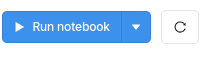

We provide starter code, however you are not required to use it as long as you properly solve the tasks.

# Classify the Oxford Flowers dataset (Weight & Biases) [6p]

In this task, you will train a convolutional neural network to classify images of flowers from the [Oxford Flowers 102 dataset](https://www.robots.ox.ac.uk/~vgg/data/flowers/102/). The dataset consists of 102 flower categories, and each class has between 40 and 258 images. The images have large scale, pose, and light variations. In addition, there are categories that have large variations within the category and several very similar categories.

    
The dataset is available in `torchvision.datasets.Flowers102` class; see [Flowers102.html](https://pytorch.org/vision/main/generated/torchvision.datasets.Flowers102.html). You can use the following code to load the dataset:

```python
import torchvision
import torchvision.transforms as transforms

dataset = torchvision.datasets.Flowers102(root='./data', download=True, transform=transforms.ToTensor())
```

**Hint**: The default split of the dataset is 1020, 1020 and 6149 images for training, validation and test sets respectively.
If you can handle the bigger training dataset, you can experiment by taking up to 80% of the test set for training.


In this task you should run several experiments to classify the images.
In order to track the experiments, you can use the `Weight & Biases` library; see the [documentation](https://docs.wandb.ai/quickstart) for more details.

Implement your code as a single Python script or a Jupyter notebook. Remember to log the experiment configuration, hyperparameters, and results (e.g., training loss, validation loss, accuracy and test loss, accuracy).
For logging, you can use the `wandb.log` function to log the metrics and hyperparameters. You can also log the model architecture, training curves, and other relevant information.

* 1. **[1p]**:
    * Your task is to implement a convolutional neural network from scratch using PyTorch.
    * Your CNN should consist of convolutional layers (Conv2D), pooling layers (MaxPooling2D), activation layers (e.g., ReLU), and fully connected layers (if needed).
    
* 2. **[2p]**:
    * Train your CNN on different training set sized (10%, 20%, 50%, 80%, 100%) and evaluate the performance on the validation set and test set.
        * Report the accuracy and loss on the validation set and test set for each training set size.
    * Train your CNN on the full training set plus 20%, 50% and 80% of the test set and evaluate the performance on the validation set and the remaining test set.
        * Report the accuracy and loss on the validation set and remaining test set for each training set size.
    * Compare the performance of your CNN on the different training set sizes and analyze the results.

* 3. **[1p]**:
    * Implement a baseline AlexNet model using PyTorch.
    * Training AlexNet may take a long time, so try to use GPU acceleration if available.

* 4. **[1p]**:
    * Input normalization: experiment with different input normalization techniques (e.g., mean subtraction, standardization) and analyze their impact on the model's performance.

* 5. **[2p]**:
    * Experiment with different hyperparameters such as learning rate, batch size, number of epochs, and optimizer choice (e.g., SGD, Adam).

* 6. **[2p]**:
    * Modify your CNN architecture to include batch normalization and dropout layers.
    * Experiment with different dropout rates and analyze their impact on the model's performance.

* 7. **[1p]**:
    * Implement data augmentation techniques such as random rotations, shifts, flips, and zooms on the training dataset.
    * Train your CNN with augmented data and compare the performance with the baseline model trained on the original data.

* 8. ***[2p extra points]***:
    * Implement residual connections in your CNN architecture; see the [ResNet paper](https://arxiv.org/abs/1512.03385) for more details.
    * Implement inception modules in your CNN architecture; see the [GoogLeNet paper](https://arxiv.org/abs/1409.4842) for more details.
                

Analyze the results obtained from different experiments.
Discuss the effects of varying training set size, hyperparameters, batch normalization, dropout, and data augmentation on the CNN's performance.
Provide insights into how these factors influence model training, convergence, and generalization.

Use the `Weight & Biases` reports to present your findings in a comprehensive report or presentation; see the [documentation](https://docs.wandb.ai/quickstart) for more details.

**[2p extra]**: present your findings (for each task) in a report format in Weight & Biases.




# ZAD.1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import wandb

wandb.init(project='flowers102-cnn', entity='kicza', name='zad.1')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
val_dataset = datasets.Flowers102(root='./data', split='val', download=True, transform=transform)
test_dataset = datasets.Flowers102(root='./data', split='test', download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=102):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 56 * 56)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN(num_classes=102)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0

num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    wandb.log({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy
    })

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch+1} due to no improvement in validation loss')
        break

    scheduler.step()

model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

wandb.log({
    'test_loss': test_loss,
    'test_accuracy': test_accuracy
})

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

wandb.finish()


epoch,▁▂▃▄▅▅▆▇█
train_accuracy,▁▁▂▃▄▇▇██
train_loss,█▇▇▅▄▂▂▁▁
val_accuracy,▁▂▄▅▆████
val_loss,█▇▅▃▂▁▁▁▁
epoch,9
train_accuracy,64.21569
train_loss,2.02586
val_accuracy,10.29412
val_loss,4.04613


Epoch [1/20], Training Loss: 4.6326, Training Accuracy: 2.06%, Validation Loss: 4.5682, Validation Accuracy: 2.06%
Epoch [2/20], Training Loss: 4.4589, Training Accuracy: 5.98%, Validation Loss: 4.4646, Validation Accuracy: 3.82%
Epoch [3/20], Training Loss: 4.2335, Training Accuracy: 8.24%, Validation Loss: 4.3629, Validation Accuracy: 6.76%
Epoch [4/20], Training Loss: 3.8965, Training Accuracy: 14.90%, Validation Loss: 4.2180, Validation Accuracy: 7.16%
Epoch [5/20], Training Loss: 3.4705, Training Accuracy: 22.84%, Validation Loss: 4.1233, Validation Accuracy: 8.63%
Epoch [6/20], Training Loss: 3.1009, Training Accuracy: 33.63%, Validation Loss: 4.0324, Validation Accuracy: 10.00%
Epoch [7/20], Training Loss: 2.9909, Training Accuracy: 39.71%, Validation Loss: 4.0083, Validation Accuracy: 9.22%
Epoch [8/20], Training Loss: 2.9284, Training Accuracy: 40.59%, Validation Loss: 3.9944, Validation Accuracy: 9.51%
Epoch [9/20], Training Loss: 2.8716, Training Accuracy: 43.53%, Validation

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_loss,▁
train_accuracy,▁▂▂▃▄▆▇▇▇███████████
train_loss,█▇▇▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▅▅▇█▇▇▇███████████
val_loss,█▇▆▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,9.59506
test_loss,4.05687
train_accuracy,47.45098


# ZAD.2

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split, ConcatDataset
import wandb

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32
NUM_EPOCHS = 20
PATIENCE = 5

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

full_train_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
val_dataset = datasets.Flowers102(root='./data', split='val', download=True, transform=transform)
full_test_dataset = datasets.Flowers102(root='./data', split='test', download=True, transform=transform)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=102):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 56 * 56)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def get_subset(dataset, ratio):
    size = int(len(dataset) * ratio)
    return random_split(dataset, [size, len(dataset) - size])[0]

def run_experiment(train_dataset, val_dataset, test_dataset, run_name):
    wandb.init(project='flowers102-cnn', entity='kicza', name=run_name)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

    model = SimpleCNN(num_classes=102).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.0001)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    best_val_loss = float('inf')
    epochs_no_improve = 0

    for epoch in range(NUM_EPOCHS):
        model.train()
        running_loss, correct, total = 0.0, 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_acc = 100 * correct / total

        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_loss /= len(val_loader)
        val_acc = 100 * correct / total

        wandb.log({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_accuracy': train_acc,
            'val_loss': val_loss,
            'val_accuracy': val_acc
        })

        print(f"[{epoch+1}/{NUM_EPOCHS}] Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print(f"Early stopping at epoch {epoch+1}")
            break

        scheduler.step()

    model.eval()
    test_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_acc = 100 * correct / total

    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%")

    wandb.log({
        'final_test_loss': test_loss,
        'final_test_accuracy': test_acc
    })

    wandb.finish()


# Part 1: Training on various training sizes
for ratio in [0.1, 0.2, 0.5, 0.8, 1.0]:
    subset = get_subset(full_train_dataset, ratio)
    run_experiment(subset, val_dataset, full_test_dataset, run_name=f"train_{int(ratio*100)}pct")

# Part 2: Add parts of test set to training
for extra_ratio in [0.2, 0.5, 0.8]:
    extra_size = int(len(full_test_dataset) * extra_ratio)
    remaining_size = len(full_test_dataset) - extra_size
    extra_test, remaining_test = random_split(full_test_dataset, [extra_size, remaining_size])
    new_train_dataset = ConcatDataset([full_train_dataset, extra_test])
    run_experiment(new_train_dataset, val_dataset, remaining_test, run_name=f"train_full+{int(extra_ratio*100)}pct_test")


[1/20] Train Loss: 4.6355, Train Acc: 0.00%, Val Loss: 4.6910, Val Acc: 1.47%
[2/20] Train Loss: 4.4132, Train Acc: 6.86%, Val Loss: 4.7598, Val Acc: 1.37%
[3/20] Train Loss: 4.2202, Train Acc: 8.82%, Val Loss: 4.8076, Val Acc: 2.25%
[4/20] Train Loss: 4.0272, Train Acc: 10.78%, Val Loss: 4.8460, Val Acc: 2.25%
[5/20] Train Loss: 3.9105, Train Acc: 14.71%, Val Loss: 4.8804, Val Acc: 1.67%
[6/20] Train Loss: 3.6812, Train Acc: 15.69%, Val Loss: 4.8805, Val Acc: 1.86%
Early stopping at epoch 6
Test Loss: 4.7568, Test Accuracy: 1.58%


epoch,▁▂▄▅▇█
final_test_accuracy,▁
final_test_loss,▁
train_accuracy,▁▄▅▆██
train_loss,█▆▅▄▃▁
val_accuracy,▂▁██▃▅
val_loss,▁▄▅▇██
epoch,6
final_test_accuracy,1.57749
final_test_loss,4.7568
train_accuracy,15.68627


[1/20] Train Loss: 4.6938, Train Acc: 0.49%, Val Loss: 4.6695, Val Acc: 1.57%
[2/20] Train Loss: 4.4842, Train Acc: 5.39%, Val Loss: 4.6482, Val Acc: 1.76%
[3/20] Train Loss: 4.3721, Train Acc: 5.88%, Val Loss: 4.6301, Val Acc: 2.55%
[4/20] Train Loss: 4.2102, Train Acc: 11.76%, Val Loss: 4.6335, Val Acc: 2.55%
[5/20] Train Loss: 4.0205, Train Acc: 16.18%, Val Loss: 4.6382, Val Acc: 3.14%
[6/20] Train Loss: 3.8718, Train Acc: 20.10%, Val Loss: 4.6379, Val Acc: 2.94%
[7/20] Train Loss: 3.8441, Train Acc: 21.57%, Val Loss: 4.6353, Val Acc: 3.14%
[8/20] Train Loss: 3.8136, Train Acc: 23.04%, Val Loss: 4.6349, Val Acc: 3.14%
Early stopping at epoch 8
Test Loss: 4.5924, Test Accuracy: 3.01%


epoch,▁▂▃▄▅▆▇█
final_test_accuracy,▁
final_test_loss,▁
train_accuracy,▁▃▃▅▆▇██
train_loss,█▆▅▄▃▁▁▁
val_accuracy,▁▂▅▅█▇██
val_loss,█▄▁▂▂▂▂▂
epoch,8
final_test_accuracy,3.00862
final_test_loss,4.59243
train_accuracy,23.03922


[1/20] Train Loss: 4.6771, Train Acc: 0.98%, Val Loss: 4.6070, Val Acc: 1.96%
[2/20] Train Loss: 4.5304, Train Acc: 3.53%, Val Loss: 4.5705, Val Acc: 2.45%
[3/20] Train Loss: 4.3918, Train Acc: 5.49%, Val Loss: 4.5429, Val Acc: 2.16%
[4/20] Train Loss: 4.2141, Train Acc: 10.39%, Val Loss: 4.5085, Val Acc: 2.45%
[5/20] Train Loss: 3.9756, Train Acc: 12.94%, Val Loss: 4.4987, Val Acc: 3.63%
[6/20] Train Loss: 3.7445, Train Acc: 22.16%, Val Loss: 4.4782, Val Acc: 4.31%
[7/20] Train Loss: 3.6816, Train Acc: 23.92%, Val Loss: 4.4710, Val Acc: 4.71%
[8/20] Train Loss: 3.6409, Train Acc: 23.33%, Val Loss: 4.4699, Val Acc: 4.71%
[9/20] Train Loss: 3.6019, Train Acc: 26.47%, Val Loss: 4.4665, Val Acc: 5.00%
[10/20] Train Loss: 3.5675, Train Acc: 27.65%, Val Loss: 4.4670, Val Acc: 4.90%
[11/20] Train Loss: 3.5371, Train Acc: 28.82%, Val Loss: 4.4669, Val Acc: 4.90%
[12/20] Train Loss: 3.5319, Train Acc: 28.82%, Val Loss: 4.4667, Val Acc: 5.00%
[13/20] Train Loss: 3.5282, Train Acc: 28.82%, Val L

epoch,▁▂▂▃▃▄▄▅▅▆▆▇▇█
final_test_accuracy,▁
final_test_loss,▁
train_accuracy,▁▂▂▃▄▆▇▇▇█████
train_loss,█▇▆▅▄▂▂▂▁▁▁▁▁▁
val_accuracy,▁▂▁▂▅▆▇▇██████
val_loss,█▆▅▃▃▂▁▁▁▁▁▁▁▁
epoch,14
final_test_accuracy,3.62661
final_test_loss,4.57434
train_accuracy,29.01961


[1/20] Train Loss: 4.6181, Train Acc: 1.10%, Val Loss: 4.5341, Val Acc: 3.14%
[2/20] Train Loss: 4.3680, Train Acc: 5.88%, Val Loss: 4.4052, Val Acc: 5.39%
[3/20] Train Loss: 4.0032, Train Acc: 17.52%, Val Loss: 4.2514, Val Acc: 7.75%
[4/20] Train Loss: 3.5009, Train Acc: 25.74%, Val Loss: 4.0939, Val Acc: 9.31%
[5/20] Train Loss: 2.8420, Train Acc: 44.98%, Val Loss: 3.9915, Val Acc: 11.27%
[6/20] Train Loss: 2.2482, Train Acc: 63.60%, Val Loss: 3.9141, Val Acc: 12.65%
[7/20] Train Loss: 2.1270, Train Acc: 69.49%, Val Loss: 3.8941, Val Acc: 13.04%
[8/20] Train Loss: 2.0422, Train Acc: 71.32%, Val Loss: 3.8842, Val Acc: 12.84%
[9/20] Train Loss: 1.9596, Train Acc: 71.45%, Val Loss: 3.8800, Val Acc: 12.75%
[10/20] Train Loss: 1.9012, Train Acc: 73.77%, Val Loss: 3.8667, Val Acc: 12.75%
[11/20] Train Loss: 1.8367, Train Acc: 75.61%, Val Loss: 3.8659, Val Acc: 12.75%
[12/20] Train Loss: 1.8292, Train Acc: 75.98%, Val Loss: 3.8658, Val Acc: 12.84%
[13/20] Train Loss: 1.8259, Train Acc: 76.2

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
final_test_accuracy,▁
final_test_loss,▁
train_accuracy,▁▁▃▃▅▇▇█████████████
train_loss,█▇▆▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▄▅▇███████████████
val_loss,█▇▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
final_test_accuracy,11.74175
final_test_loss,4.1685
train_accuracy,76.34804


[1/20] Train Loss: 4.6442, Train Acc: 1.96%, Val Loss: 4.5673, Val Acc: 3.33%
[2/20] Train Loss: 4.4897, Train Acc: 3.82%, Val Loss: 4.4802, Val Acc: 2.94%
[3/20] Train Loss: 4.3335, Train Acc: 5.88%, Val Loss: 4.3867, Val Acc: 5.29%
[4/20] Train Loss: 4.0870, Train Acc: 9.51%, Val Loss: 4.2668, Val Acc: 6.76%
[5/20] Train Loss: 3.7901, Train Acc: 16.76%, Val Loss: 4.1629, Val Acc: 7.16%
[6/20] Train Loss: 3.4842, Train Acc: 26.08%, Val Loss: 4.1043, Val Acc: 8.82%
[7/20] Train Loss: 3.3958, Train Acc: 29.80%, Val Loss: 4.0846, Val Acc: 8.82%
[8/20] Train Loss: 3.3429, Train Acc: 30.00%, Val Loss: 4.0720, Val Acc: 9.31%
[9/20] Train Loss: 3.3015, Train Acc: 30.69%, Val Loss: 4.0624, Val Acc: 10.00%
[10/20] Train Loss: 3.2557, Train Acc: 33.04%, Val Loss: 4.0523, Val Acc: 9.41%
[11/20] Train Loss: 3.2169, Train Acc: 34.22%, Val Loss: 4.0513, Val Acc: 9.71%
[12/20] Train Loss: 3.2124, Train Acc: 34.31%, Val Loss: 4.0505, Val Acc: 9.71%
[13/20] Train Loss: 3.2075, Train Acc: 34.22%, Val L

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
final_test_accuracy,▁
final_test_loss,▁
train_accuracy,▁▁▂▃▄▆▇▇▇███████████
train_loss,█▇▆▅▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▃▅▅▇▇▇█▇███▇██████
val_loss,█▇▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
final_test_accuracy,9.04212
final_test_loss,4.14278
train_accuracy,34.70588


[1/20] Train Loss: 4.6229, Train Acc: 1.51%, Val Loss: 4.6207, Val Acc: 1.86%
[2/20] Train Loss: 4.5226, Train Acc: 3.73%, Val Loss: 4.5719, Val Acc: 2.75%
[3/20] Train Loss: 4.3715, Train Acc: 5.47%, Val Loss: 4.5228, Val Acc: 3.24%
[4/20] Train Loss: 4.1750, Train Acc: 9.38%, Val Loss: 4.4161, Val Acc: 5.29%
[5/20] Train Loss: 3.9174, Train Acc: 13.92%, Val Loss: 4.3775, Val Acc: 6.76%
[6/20] Train Loss: 3.6832, Train Acc: 19.74%, Val Loss: 4.2898, Val Acc: 7.45%
[7/20] Train Loss: 3.6301, Train Acc: 21.12%, Val Loss: 4.2774, Val Acc: 7.35%
[8/20] Train Loss: 3.5959, Train Acc: 20.94%, Val Loss: 4.2745, Val Acc: 8.43%
[9/20] Train Loss: 3.5670, Train Acc: 22.01%, Val Loss: 4.2623, Val Acc: 7.94%
[10/20] Train Loss: 3.5447, Train Acc: 22.41%, Val Loss: 4.2532, Val Acc: 8.53%
[11/20] Train Loss: 3.5081, Train Acc: 23.34%, Val Loss: 4.2513, Val Acc: 8.53%
[12/20] Train Loss: 3.5040, Train Acc: 23.61%, Val Loss: 4.2504, Val Acc: 8.53%
[13/20] Train Loss: 3.4990, Train Acc: 23.70%, Val Lo

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
final_test_accuracy,▁
final_test_loss,▁
train_accuracy,▁▂▂▃▅▇▇▇▇███████████
train_loss,█▇▆▅▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▂▄▆▇▇█▇███████████
val_loss,█▇▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
final_test_accuracy,13.59756
final_test_loss,3.94893
train_accuracy,23.87728


[1/20] Train Loss: 4.5228, Train Acc: 3.76%, Val Loss: 4.5448, Val Acc: 2.84%
[2/20] Train Loss: 4.2254, Train Acc: 8.35%, Val Loss: 4.4322, Val Acc: 5.10%
[3/20] Train Loss: 3.8635, Train Acc: 13.95%, Val Loss: 4.2519, Val Acc: 6.76%
[4/20] Train Loss: 3.4564, Train Acc: 20.00%, Val Loss: 4.0103, Val Acc: 8.53%
[5/20] Train Loss: 3.0440, Train Acc: 27.04%, Val Loss: 3.9024, Val Acc: 11.27%
[6/20] Train Loss: 2.6484, Train Acc: 36.79%, Val Loss: 3.7474, Val Acc: 13.73%
[7/20] Train Loss: 2.5745, Train Acc: 38.08%, Val Loss: 3.7335, Val Acc: 13.73%
[8/20] Train Loss: 2.5241, Train Acc: 40.03%, Val Loss: 3.7264, Val Acc: 13.53%
[9/20] Train Loss: 2.4804, Train Acc: 40.91%, Val Loss: 3.7079, Val Acc: 13.82%
[10/20] Train Loss: 2.4391, Train Acc: 41.79%, Val Loss: 3.6882, Val Acc: 14.22%
[11/20] Train Loss: 2.3998, Train Acc: 42.70%, Val Loss: 3.6815, Val Acc: 14.71%
[12/20] Train Loss: 2.3923, Train Acc: 42.82%, Val Loss: 3.6801, Val Acc: 14.61%
[13/20] Train Loss: 2.3878, Train Acc: 42.9

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
final_test_accuracy,▁
final_test_loss,▁
train_accuracy,▁▂▃▄▅▇▇▇████████████
train_loss,█▇▆▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▄▆▇▇▇▇███████████
val_loss,█▇▆▄▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
final_test_accuracy,24.29268
final_test_loss,3.26402
train_accuracy,43.45383


[1/20] Train Loss: 4.2104, Train Acc: 8.82%, Val Loss: 4.2372, Val Acc: 6.86%
[2/20] Train Loss: 3.4435, Train Acc: 19.57%, Val Loss: 3.7054, Val Acc: 12.35%
[3/20] Train Loss: 2.8395, Train Acc: 30.36%, Val Loss: 3.3862, Val Acc: 20.00%
[4/20] Train Loss: 2.3684, Train Acc: 40.63%, Val Loss: 3.1761, Val Acc: 22.55%
[5/20] Train Loss: 1.9698, Train Acc: 49.96%, Val Loss: 3.0773, Val Acc: 26.37%
[6/20] Train Loss: 1.5148, Train Acc: 64.29%, Val Loss: 3.0091, Val Acc: 27.35%
[7/20] Train Loss: 1.4388, Train Acc: 66.49%, Val Loss: 3.0029, Val Acc: 27.55%
[8/20] Train Loss: 1.3958, Train Acc: 67.10%, Val Loss: 3.0156, Val Acc: 27.84%
[9/20] Train Loss: 1.3513, Train Acc: 68.66%, Val Loss: 3.0225, Val Acc: 28.24%
[10/20] Train Loss: 1.3087, Train Acc: 69.76%, Val Loss: 3.0270, Val Acc: 28.14%
[11/20] Train Loss: 1.2626, Train Acc: 71.16%, Val Loss: 3.0169, Val Acc: 28.14%
[12/20] Train Loss: 1.2549, Train Acc: 71.44%, Val Loss: 3.0188, Val Acc: 28.04%
Early stopping at epoch 12
Test Loss: 2

epoch,▁▂▂▃▄▄▅▅▆▇▇█
final_test_accuracy,▁
final_test_loss,▁
train_accuracy,▁▂▃▅▆▇▇█████
train_loss,█▆▅▄▃▂▁▁▁▁▁▁
val_accuracy,▁▃▅▆▇███████
val_loss,█▅▃▂▁▁▁▁▁▁▁▁
epoch,12
final_test_accuracy,35.77236
final_test_loss,2.66
train_accuracy,71.443


# ZAD. 3 - ALEXNET

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import wandb

wandb.init(project='flowers102-alexnet', entity='kicza', name='zad3-alex')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
val_dataset = datasets.Flowers102(root='./data', split='val', download=True, transform=transform)
test_dataset = datasets.Flowers102(root='./data', split='test', download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

class AlexNet(nn.Module):
    def __init__(self, num_classes=102):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(96, 256, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(256, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 5 * 5, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes)
        )
        self._initialize_weights()

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
                if m.bias is not None:
                    nn.init.zeros_(m.bias)

model = AlexNet(num_classes=102).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    wandb.log({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy
    })

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch+1}')
        break

    scheduler.step()

model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

wandb.log({
    'test_loss': test_loss,
    'test_accuracy': test_accuracy
})

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

wandb.finish()


Epoch [1/20], Training Loss: 5.5150, Training Accuracy: 0.78%, Validation Loss: 4.5786, Validation Accuracy: 2.84%
Epoch [2/20], Training Loss: 4.5373, Training Accuracy: 2.16%, Validation Loss: 4.3396, Validation Accuracy: 4.02%
Epoch [3/20], Training Loss: 4.3337, Training Accuracy: 3.33%, Validation Loss: 4.1309, Validation Accuracy: 6.76%
Epoch [4/20], Training Loss: 4.1328, Training Accuracy: 5.39%, Validation Loss: 3.9662, Validation Accuracy: 9.12%
Epoch [5/20], Training Loss: 3.8825, Training Accuracy: 10.00%, Validation Loss: 3.7507, Validation Accuracy: 11.57%
Epoch [6/20], Training Loss: 3.5795, Training Accuracy: 13.73%, Validation Loss: 3.6330, Validation Accuracy: 13.82%
Epoch [7/20], Training Loss: 3.4345, Training Accuracy: 16.86%, Validation Loss: 3.5457, Validation Accuracy: 15.78%
Epoch [8/20], Training Loss: 3.2892, Training Accuracy: 18.92%, Validation Loss: 3.4956, Validation Accuracy: 17.16%
Epoch [9/20], Training Loss: 3.2281, Training Accuracy: 20.69%, Validati

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▂▂▃▄▅▆▆▆▇▇▇▇▇▇█▇█▇
train_loss,█▅▅▄▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▃▄▅▅▆▇▇███████████
val_loss,█▇▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,15.59603
test_loss,3.5311
train_accuracy,24.90196


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader
import wandb

wandb.init(project='flowers102-alexnet', entity='kicza', name='zad3-alexnet-built-in')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
val_dataset = datasets.Flowers102(root='./data', split='val', download=True, transform=transform)
test_dataset = datasets.Flowers102(root='./data', split='test', download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

model = models.alexnet(pretrained=True)
model.classifier[6] = nn.Linear(model.classifier[6].in_features, 102)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total

    wandb.log({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy
    })

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping at epoch {epoch+1} due to no improvement in validation loss")
        break

    scheduler.step()

model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

wandb.log({
    'test_loss': test_loss,
    'test_accuracy': test_accuracy
})

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

wandb.finish()


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:01<00:00, 175MB/s]


Epoch [1/20], Training Loss: 4.2484, Training Accuracy: 9.22%, Validation Loss: 2.8604, Validation Accuracy: 38.82%
Epoch [2/20], Training Loss: 1.6310, Training Accuracy: 57.16%, Validation Loss: 1.4653, Validation Accuracy: 60.59%
Epoch [3/20], Training Loss: 0.5691, Training Accuracy: 83.53%, Validation Loss: 1.3324, Validation Accuracy: 66.18%
Epoch [4/20], Training Loss: 0.2106, Training Accuracy: 94.12%, Validation Loss: 1.2079, Validation Accuracy: 68.92%
Epoch [5/20], Training Loss: 0.0885, Training Accuracy: 97.84%, Validation Loss: 1.3556, Validation Accuracy: 68.24%
Epoch [6/20], Training Loss: 0.0643, Training Accuracy: 98.43%, Validation Loss: 1.1397, Validation Accuracy: 71.86%
Epoch [7/20], Training Loss: 0.0218, Training Accuracy: 99.51%, Validation Loss: 1.0784, Validation Accuracy: 73.14%
Epoch [8/20], Training Loss: 0.0158, Training Accuracy: 99.90%, Validation Loss: 1.0593, Validation Accuracy: 73.92%
Epoch [9/20], Training Loss: 0.0143, Training Accuracy: 99.71%, V

epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▅▇██████████
train_loss,█▄▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▆▇▇████████
val_loss,█▃▂▂▂▁▁▁▁▁▁▁▁
epoch,13
test_accuracy,70.62937
test_loss,1.31596
train_accuracy,100


# ZAD. 4

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import wandb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 32
num_epochs = 20
learning_rate = 0.0001
patience = 5

def get_mean_std(dataset):
    loader = DataLoader(dataset, batch_size=64, shuffle=False)
    mean = 0.
    std = 0.
    total_images = 0
    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples
    mean /= total_images
    std /= total_images
    return mean, std

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=102):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 56 * 56)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

normalizations = ['no_normalization', 'custom', 'minmax']

for norm_type in normalizations:
    wandb.init(project='flowers102-cnn', entity='kicza', name=f'norm-{norm_type}', reinit=True)
    wandb.config.normalization = norm_type

    if norm_type == 'no_normalization':
        # No normalization applied
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()  # No normalization, just converting image to tensor
        ])
    elif norm_type == 'custom':
        # Custom normalization using mean and std from the dataset
        temp_transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor()
        ])
        temp_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=temp_transform)
        mean, std = get_mean_std(temp_dataset)
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean.tolist(), std.tolist())
        ])
    elif norm_type == 'minmax':
        # Min-Max normalization (scaling pixel values to [-1, 1])
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),  # Scales to [0, 1] by default
            transforms.Lambda(lambda x: (x - 0.5) * 2)  # Rescale to [-1, 1]
        ])

    train_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
    val_dataset = datasets.Flowers102(root='./data', split='val', download=True, transform=transform)
    test_dataset = datasets.Flowers102(root='./data', split='test', download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = SimpleCNN(num_classes=102).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    best_val_loss = float('inf')
    epochs_without_improvement = 0

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total

        wandb.log({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy
        })

        print(f'{norm_type} | Epoch {epoch+1} | Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f} | Val Acc: {val_accuracy:.2f}%')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            break

        scheduler.step()

    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = 100 * correct / total

    wandb.log({
        'test_loss': test_loss,
        'test_accuracy': test_accuracy
    })

    print(f'{norm_type} | Test Loss: {test_loss:.4f} | Test Acc: {test_accuracy:.2f}%')

    wandb.finish()


no_normalization | Epoch 1 | Train Loss: 4.6538 | Val Loss: 4.6118 | Val Acc: 2.25%
no_normalization | Epoch 2 | Train Loss: 4.5879 | Val Loss: 4.5799 | Val Acc: 1.47%
no_normalization | Epoch 3 | Train Loss: 4.5120 | Val Loss: 4.5230 | Val Acc: 3.14%
no_normalization | Epoch 4 | Train Loss: 4.3877 | Val Loss: 4.4423 | Val Acc: 4.31%
no_normalization | Epoch 5 | Train Loss: 4.2259 | Val Loss: 4.3675 | Val Acc: 3.82%
no_normalization | Epoch 6 | Train Loss: 4.0681 | Val Loss: 4.3375 | Val Acc: 4.51%
no_normalization | Epoch 7 | Train Loss: 4.0160 | Val Loss: 4.3264 | Val Acc: 5.20%
no_normalization | Epoch 8 | Train Loss: 3.9862 | Val Loss: 4.3167 | Val Acc: 5.59%
no_normalization | Epoch 9 | Train Loss: 3.9513 | Val Loss: 4.3036 | Val Acc: 5.69%
no_normalization | Epoch 10 | Train Loss: 3.9201 | Val Loss: 4.2946 | Val Acc: 5.10%
no_normalization | Epoch 11 | Train Loss: 3.8923 | Val Loss: 4.2936 | Val Acc: 5.29%
no_normalization | Epoch 12 | Train Loss: 3.8894 | Val Loss: 4.2931 | Val 

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_loss,▁
train_accuracy,▁▂▂▃▅▅▆▆▇▇██████████
train_loss,█▇▇▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▂▁▄▆▅▆▇██▇▇▇▇▇▇▇▇▇▇▇
val_loss,█▇▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,5.12278
test_loss,4.33081
train_accuracy,12.35294


custom | Epoch 1 | Train Loss: 4.6546 | Val Loss: 4.5650 | Val Acc: 2.25%
custom | Epoch 2 | Train Loss: 4.4473 | Val Loss: 4.4948 | Val Acc: 3.14%
custom | Epoch 3 | Train Loss: 4.2154 | Val Loss: 4.4074 | Val Acc: 5.78%
custom | Epoch 4 | Train Loss: 3.8789 | Val Loss: 4.3011 | Val Acc: 6.67%
custom | Epoch 5 | Train Loss: 3.4105 | Val Loss: 4.2364 | Val Acc: 7.65%
custom | Epoch 6 | Train Loss: 2.9176 | Val Loss: 4.1554 | Val Acc: 9.61%
custom | Epoch 7 | Train Loss: 2.8004 | Val Loss: 4.1506 | Val Acc: 10.10%
custom | Epoch 8 | Train Loss: 2.7310 | Val Loss: 4.1409 | Val Acc: 10.10%
custom | Epoch 9 | Train Loss: 2.6671 | Val Loss: 4.1400 | Val Acc: 10.00%
custom | Epoch 10 | Train Loss: 2.6056 | Val Loss: 4.1416 | Val Acc: 10.20%
custom | Epoch 11 | Train Loss: 2.5504 | Val Loss: 4.1399 | Val Acc: 10.20%
custom | Epoch 12 | Train Loss: 2.5424 | Val Loss: 4.1383 | Val Acc: 10.29%
custom | Epoch 13 | Train Loss: 2.5368 | Val Loss: 4.1373 | Val Acc: 10.20%
custom | Epoch 14 | Train L

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_loss,▁
train_accuracy,▁▂▂▃▄▆▇▇▇███████████
train_loss,█▇▇▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▄▅▆▇██████████████
val_loss,█▇▅▄▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,7.54594
test_loss,4.32931
train_accuracy,53.03922


minmax | Epoch 1 | Train Loss: 4.6429 | Val Loss: 4.5765 | Val Acc: 2.84%
minmax | Epoch 2 | Train Loss: 4.4968 | Val Loss: 4.4923 | Val Acc: 3.43%
minmax | Epoch 3 | Train Loss: 4.3121 | Val Loss: 4.3923 | Val Acc: 5.00%
minmax | Epoch 4 | Train Loss: 4.0132 | Val Loss: 4.2801 | Val Acc: 7.45%
minmax | Epoch 5 | Train Loss: 3.6219 | Val Loss: 4.1457 | Val Acc: 8.82%
minmax | Epoch 6 | Train Loss: 3.1867 | Val Loss: 4.1026 | Val Acc: 9.71%
minmax | Epoch 7 | Train Loss: 3.0923 | Val Loss: 4.0844 | Val Acc: 10.59%
minmax | Epoch 8 | Train Loss: 3.0333 | Val Loss: 4.0748 | Val Acc: 10.49%
minmax | Epoch 9 | Train Loss: 2.9716 | Val Loss: 4.0632 | Val Acc: 10.78%
minmax | Epoch 10 | Train Loss: 2.9144 | Val Loss: 4.0574 | Val Acc: 11.18%
minmax | Epoch 11 | Train Loss: 2.8692 | Val Loss: 4.0559 | Val Acc: 11.27%
minmax | Epoch 12 | Train Loss: 2.8622 | Val Loss: 4.0541 | Val Acc: 11.18%
minmax | Epoch 13 | Train Loss: 2.8557 | Val Loss: 4.0531 | Val Acc: 11.08%
minmax | Epoch 14 | Train L

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▂▃▄▆▇▇▇███████████
train_loss,█▇▇▆▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▃▅▆▇▇▇████████████
val_loss,█▇▆▄▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,8.47292
test_loss,4.21441
train_accuracy,46.37255


#ZAD. 5

In [ ]:
!pip install wandb --upgrade

import wandb
wandb.login()

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
val_dataset = datasets.Flowers102(root='./data', split='val', download=True, transform=transform)
test_dataset = datasets.Flowers102(root='./data', split='test', download=True, transform=transform)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=102):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 56 * 56)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x


sweep_config = {
    'method': 'bayes',
    'metric': {
        'name': 'val_accuracy',
        'goal': 'maximize'
    },
    'parameters': {
        'learning_rate': {'min': 1e-5, 'max': 1e-3},
        'batch_size': {'values': [32, 64]},
        'optimizer': {'values': ['Adam', 'SGD']},
        'num_epochs': {'value': 20}
    }
}


def train():
    wandb.init(project="flowers102-cnn")
    config = wandb.config

    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

    model = SimpleCNN().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = getattr(optim, config.optimizer)(model.parameters(), lr=config.learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)

    best_val_loss = float('inf')
    patience = 5
    epochs_no_improve = 0

    for epoch in range(config.num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total

        wandb.log({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy
        })

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1

        if epochs_no_improve >= patience:
            print(f"Early stopping at epoch {epoch+1}")
            break

        scheduler.step()


    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total

    wandb.log({'test_loss': test_loss, 'test_accuracy': test_accuracy})
    wandb.finish()


sweep_id = wandb.sweep(sweep_config, project="flowers102-cnn")
wandb.agent(sweep_id, function=train)


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: kicza to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
100%|██████████| 345M/345M [00:21<00:00, 15.9MB/s]
100%|██████████| 502/502 [00:00<00:00, 1.05MB/s]
100%|██████████| 15.0k/15.0k [00:00<00:00, 25.6MB/s]


Create sweep with ID: vr3xpu9o
Sweep URL: https://wandb.ai/kicza/flowers102-cnn/sweeps/vr3xpu9o


wandb: Agent Starting Run: vywkah78 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0002771140595913371
wandb: 	num_epochs: 20
wandb: 	optimizer: SGD


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_loss,▁
train_accuracy,▆▇▆▁▆▆▆▆▇▇▇█████████
train_loss,█▇▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▃▃▁▃▅▅▆█████████████
val_loss,█▆▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,1.05708
test_loss,4.62143
train_accuracy,1.37255


wandb: Agent Starting Run: wei2tqkz with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 5.413192931174298e-05
wandb: 	num_epochs: 20
wandb: 	optimizer: SGD


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▃▅████████████████
train_loss,█▇▅▄▄▂▂▁▁▁▁▁▁▁▂▁▁▁▁▁
val_accuracy,█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,0.65051
test_loss,4.62288
train_accuracy,1.07843


wandb: Agent Starting Run: a1q16yd1 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0005264263326796233
wandb: 	num_epochs: 20
wandb: 	optimizer: SGD


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_loss,▁
train_accuracy,▅▃▁▃▅████▇██████████
train_loss,█▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▅▁▁▁▁▁▁███████████
val_loss,█▆▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,1.49618
test_loss,4.61672
train_accuracy,1.27451


wandb: Agent Starting Run: zx3hnnhs with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.00020598118673550192
wandb: 	num_epochs: 20
wandb: 	optimizer: SGD


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_loss,▁
train_accuracy,█▆▁█▆█████▆▆▆▆▆▆▆▆▆▆
train_loss,█▇▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,█▆▃▃▁▁▁▃▃▃▃▃▃▃▃▃▃▃▃▃
val_loss,█▆▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,0.81314
test_loss,4.61772
train_accuracy,0.98039


wandb: Agent Starting Run: hxz018ad with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0006326675110340527
wandb: 	num_epochs: 20
wandb: 	optimizer: SGD


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▄▅▄██▇▇▇▇▇▇▇▇▇▇▇▇▇
train_loss,█▇▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,█▅▅▁▅▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,1.47992
test_loss,4.61803
train_accuracy,1.96078


wandb: Agent Starting Run: sm6p4zn7 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.00045834381786524016
wandb: 	num_epochs: 20
wandb: 	optimizer: SGD


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_loss,▁
train_accuracy,▁█▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
train_loss,█▇▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,█▅▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▇▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,0.50415
test_loss,4.62089
train_accuracy,1.07843


wandb: Agent Starting Run: ptxm6swm with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0007635039540354783
wandb: 	num_epochs: 20
wandb: 	optimizer: SGD


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▄▅▆▇████████▇█████
train_loss,█▇▆▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▅▇█▇▇▇▇▇▇▇▇▇▇▇▇▇▇▇
val_loss,█▇▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,2.86225
test_loss,4.61615
train_accuracy,3.33333


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 4clol797 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.000771583093425089
wandb: 	num_epochs: 20
wandb: 	optimizer: SGD


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_loss,▁
train_accuracy,▂▁▂▆▅▇▇▇█▇██████████
train_loss,█▇▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▂▁▄▄▆▆▆▇████████████
val_loss,█▆▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,2.91104
test_loss,4.60484
train_accuracy,4.21569


wandb: Agent Starting Run: spli74zp with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0007330976177507225
wandb: 	num_epochs: 20
wandb: 	optimizer: SGD


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▄▅▇██▇▇▇▇▇▇▇▇▇▇▇▇▇
train_loss,█▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▃▃▆▆▆▆████████████
val_loss,█▆▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,2.55326
test_loss,4.62425
train_accuracy,1.27451


wandb: Agent Starting Run: wtxzjhvg with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0007356586844253648
wandb: 	num_epochs: 20
wandb: 	optimizer: SGD


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_loss,▁
train_accuracy,▁▂▂▆▂▇▇▇█▇██████████
train_loss,█▇▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▃▁▃▆█▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
val_loss,█▆▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,1.88649
test_loss,4.62226
train_accuracy,2.2549


wandb: Agent Starting Run: vh4vj4ke with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005207205766445922
wandb: 	num_epochs: 20
wandb: 	optimizer: Adam


Early stopping at epoch 12


epoch,▁▂▂▃▄▄▅▅▆▇▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▁▂▃▆▇▇▇███
train_loss,██▇▆▄▃▂▂▂▁▁▁
val_accuracy,▁▁▃▄▅▇██████
val_loss,█▇▆▄▃▁▁▁▁▁▁▁
epoch,12
test_accuracy,11.70922
test_loss,4.04241
train_accuracy,74.11765


wandb: Agent Starting Run: 4uky3owr with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0004832912908061893
wandb: 	num_epochs: 20
wandb: 	optimizer: SGD


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_loss,▁
train_accuracy,▁▃▁▁▆▆▆▆▆▆▆▆████████
train_loss,█▇▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▅▅█████████████████
val_loss,█▆▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,0.53667
test_loss,4.62107
train_accuracy,1.17647


wandb: Agent Starting Run: h9c4rtjx with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0005743977300598621
wandb: 	num_epochs: 20
wandb: 	optimizer: SGD


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_loss,▁
train_accuracy,▃▁▄▆█▆▆▇▇▇▇▇▇▇▇▇▇▇▇▇
train_loss,█▇▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▆████████████████
val_loss,█▆▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,1.62628
test_loss,4.63156
train_accuracy,1.56863


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: h95yr8h0 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0005566669489973419
wandb: 	num_epochs: 20
wandb: 	optimizer: SGD


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_loss,▁
train_accuracy,▁▆▄▇████████████████
train_loss,█▇▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▄▄▄▆▆▆▇▇▇▇▇███████
val_loss,█▆▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,0.91072
test_loss,4.62553
train_accuracy,1.56863


wandb: Agent Starting Run: 15foqroz with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0009619985771814636
wandb: 	num_epochs: 20
wandb: 	optimizer: Adam


Early stopping at epoch 11


epoch,▁▂▂▃▄▅▅▆▇▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▁▂▄▆▇▇███
train_loss,█▇▇▅▄▂▂▂▁▁▁
val_accuracy,▁▂▃▅▆▇█████
val_loss,█▇▄▁▃▁▁▂▃▃▄
epoch,11
test_accuracy,13.17287
test_loss,4.42766
train_accuracy,85.09804


wandb: Agent Starting Run: kwcjcabl with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.000942188467343355
wandb: 	num_epochs: 20
wandb: 	optimizer: Adam


Early stopping at epoch 12


epoch,▁▂▂▃▄▄▅▅▆▇▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▂▂▄▆▇▇▇███
train_loss,█▇▇▆▄▃▂▂▁▁▁▁
val_accuracy,▁▂▄▅▆▇██████
val_loss,█▇▅▃▄▁▁▂▂▃▃▃
epoch,12
test_accuracy,14.44137
test_loss,4.34527
train_accuracy,83.82353


wandb: Agent Starting Run: v82a89ne with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0009919371362704752
wandb: 	num_epochs: 20
wandb: 	optimizer: SGD


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_loss,▁
train_accuracy,▁▇▄▂█▅▅▅▅▅▅▅▅▅▅▅▅▅▅▅
train_loss,█▇▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▅█▅█▁▁▁▅▅▅▅▅▅▅▅▅▅▅▅▅
val_loss,█▆▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,1.47992
test_loss,4.62943
train_accuracy,1.27451


wandb: Agent Starting Run: hwi6ofk4 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0009934467941463024
wandb: 	num_epochs: 20
wandb: 	optimizer: SGD


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_loss,▁
train_accuracy,▁▂▃▅█▆▇█████████████
train_loss,█▇▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,█▅▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂
val_loss,█▆▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,1.31729
test_loss,4.62478
train_accuracy,1.66667


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: a8mjzdo5 with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0005924126640116611
wandb: 	num_epochs: 20
wandb: 	optimizer: Adam


Early stopping at epoch 8


epoch,▁▂▃▄▅▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▃▅▇███
train_loss,█▇▆▄▂▁▁▁
val_accuracy,▁▂▅▇▆▇██
val_loss,▇▃▁▃█▅▅▅
epoch,8
test_accuracy,14.83168
test_loss,4.63435
train_accuracy,99.60784


wandb: Agent Starting Run: p09dipmd with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0001822255460030121
wandb: 	num_epochs: 20
wandb: 	optimizer: SGD


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_loss,▁
train_accuracy,▁▂▃▆▆███████████████
train_loss,█▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▂▁▄█▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆▆
val_loss,█▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,2.52074
test_loss,4.61806
train_accuracy,2.45098


wandb: Agent Starting Run: lyq77xdb with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0009203507666035653
wandb: 	num_epochs: 20
wandb: 	optimizer: Adam


Early stopping at epoch 8


epoch,▁▂▃▄▅▆▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▂▄▆███
train_loss,█▇▆▄▂▁▁▁
val_accuracy,▁▃▅▆▇███
val_loss,▇▄▁▂█▄▄▅
epoch,8
test_accuracy,16.45796
test_loss,4.65848
train_accuracy,99.5098


wandb: Agent Starting Run: 48z5tosd with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.00036867976907399585
wandb: 	num_epochs: 20
wandb: 	optimizer: SGD


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_loss,▁
train_accuracy,▁▂▁▂▅▅▅▇▇▇██████████
train_loss,█▇▆▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▆█▆████████████████
val_loss,█▆▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,1.1384
test_loss,4.63014
train_accuracy,1.47059


wandb: Agent Starting Run: vb4s9xtm with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0007789411718121428
wandb: 	num_epochs: 20
wandb: 	optimizer: SGD


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▂▂▂▅▅▆▇▆██████████
train_loss,█▇▆▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▅▆▇▇██▇▇▇▇▇▇▇▇▇▇▇▇
val_loss,█▇▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,1.34981
test_loss,4.62564
train_accuracy,2.45098


wandb: Agent Starting Run: 0ayv9lod with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 0.0007581489125021393
wandb: 	num_epochs: 20
wandb: 	optimizer: Adam


Early stopping at epoch 11


epoch,▁▂▂▃▄▅▅▆▇▇█
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▂▄▆██████
train_loss,█▇▆▄▃▁▁▁▁▁▁
val_accuracy,▁▂▄▆▆▇█████
val_loss,█▅▁▁▅▁▂▂▃▄▄
epoch,11
test_accuracy,18.05172
test_loss,4.3554
train_accuracy,99.70588


wandb: Agent Starting Run: ks9gnc2p with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0007120591942196387
wandb: 	num_epochs: 20
wandb: 	optimizer: SGD


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_loss,▁
train_accuracy,▁▄▅▇▇▇▇█████████████
train_loss,█▇▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,█▁██▁▁██████████████
val_loss,█▆▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,1.85396
test_loss,4.62265
train_accuracy,2.15686


wandb: Agent Starting Run: pm7vi4jw with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.0008191304424974205
wandb: 	num_epochs: 20
wandb: 	optimizer: SGD


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_loss,▁
train_accuracy,▄▅▁▂▄██▇█▇▇▇▇▇▇▇▇▇▇▇
train_loss,█▇▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▇█▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
val_loss,█▆▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,0.99203
test_loss,4.62161
train_accuracy,1.17647


wandb: Agent Starting Run: yjnk5cbj with config:
wandb: 	batch_size: 32
wandb: 	learning_rate: 7.06025404160829e-05
wandb: 	num_epochs: 20
wandb: 	optimizer: SGD


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_loss,▁
train_accuracy,████▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,█▇▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁█▄█████████████████
val_loss,█▆▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,0.52041
test_loss,4.62163
train_accuracy,0.98039


wandb: Agent Starting Run: y2w3v0j5 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 0.00026121952319183375
wandb: 	num_epochs: 20
wandb: 	optimizer: SGD


# ZAD. 6

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import wandb

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

dropout_rates = [0.1, 0.2, 0.3]

for dropout_rate in dropout_rates:
    wandb.init(project='flowers102-cnn', entity='kicza', name=f'zad_dropout_{dropout_rate}')

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])


    train_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=transform)
    val_dataset = datasets.Flowers102(root='./data', split='val', download=True, transform=transform)
    test_dataset = datasets.Flowers102(root='./data', split='test', download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

    class SimpleCNN(nn.Module):
        def __init__(self, num_classes=102, dropout_rate=0.5):
            super(SimpleCNN, self).__init__()


            self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
            self.bn1 = nn.BatchNorm2d(16)
            self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
            self.bn2 = nn.BatchNorm2d(32)

            self.pool = nn.MaxPool2d(2, 2)

            self.fc1 = nn.Linear(32 * 56 * 56, 128)
            self.fc2 = nn.Linear(128, num_classes)

            self.dropout = nn.Dropout(p=dropout_rate)

            self.relu = nn.ReLU()

        def forward(self, x):
            x = self.relu(self.bn1(self.conv1(x)))
            x = self.pool(x)
            x = self.relu(self.bn2(self.conv2(x)))
            x = self.pool(x)

            x = x.view(-1, 32 * 56 * 56)  # Flatten for fully connected layer
            x = self.relu(self.fc1(x))

            x = self.dropout(x)
            x = self.fc2(x)
            return x

    model = SimpleCNN(num_classes=102, dropout_rate=dropout_rate)
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.00005)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


    patience = 5
    best_val_loss = float('inf')
    epochs_without_improvement = 0
    num_epochs = 30

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_loss = val_loss / len(val_loader)
        val_accuracy = 100 * correct / total

        wandb.log({
            'epoch': epoch + 1,
            'train_loss': train_loss,
            'train_accuracy': train_accuracy,
            'val_loss': val_loss,
            'val_accuracy': val_accuracy,
            'dropout_rate': dropout_rate
        })

        print(f'Epoch [{epoch+1}/{num_epochs}], '
              f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, '
              f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1

        if epochs_without_improvement >= patience:
            print(f'Early stopping at epoch {epoch+1} due to no improvement in validation loss')
            break

        scheduler.step()

    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_loss = test_loss / len(test_loader)
    test_accuracy = 100 * correct / total

    wandb.log({
        'test_loss': test_loss,
        'test_accuracy': test_accuracy
    })

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

    wandb.finish()


Epoch [1/30], Training Loss: 4.6682, Training Accuracy: 1.57%, Validation Loss: 4.5573, Validation Accuracy: 1.47%
Epoch [2/30], Training Loss: 4.3536, Training Accuracy: 4.80%, Validation Loss: 4.4693, Validation Accuracy: 4.02%
Epoch [3/30], Training Loss: 4.1878, Training Accuracy: 8.14%, Validation Loss: 4.4580, Validation Accuracy: 4.61%
Epoch [4/30], Training Loss: 3.9635, Training Accuracy: 11.76%, Validation Loss: 4.4132, Validation Accuracy: 4.02%
Epoch [5/30], Training Loss: 3.6847, Training Accuracy: 17.84%, Validation Loss: 4.3761, Validation Accuracy: 5.00%
Epoch [6/30], Training Loss: 3.4216, Training Accuracy: 23.43%, Validation Loss: 4.3439, Validation Accuracy: 5.20%
Epoch [7/30], Training Loss: 3.3418, Training Accuracy: 25.29%, Validation Loss: 4.3330, Validation Accuracy: 5.98%
Epoch [8/30], Training Loss: 3.3111, Training Accuracy: 25.88%, Validation Loss: 4.3295, Validation Accuracy: 5.69%
Epoch [9/30], Training Loss: 3.2834, Training Accuracy: 27.84%, Validation 

dropout_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▃▃▄▄▅▅▅▆▆▇▇██
test_accuracy,▁
test_loss,▁
train_accuracy,▁▂▃▃▅▆▆▇▇▇▇▇▇██▇█
train_loss,█▇▆▅▃▂▂▂▂▁▁▁▁▁▁▁▁
val_accuracy,▁▅▅▅▆▆▇▇███████▇█
val_loss,█▅▅▄▃▂▁▁▁▁▁▁▁▁▁▁▁
dropout_rate,0.1
epoch,17
test_accuracy,6.50512


Epoch [1/30], Training Loss: 4.6761, Training Accuracy: 1.76%, Validation Loss: 4.5601, Validation Accuracy: 2.16%
Epoch [2/30], Training Loss: 4.4133, Training Accuracy: 3.43%, Validation Loss: 4.4853, Validation Accuracy: 2.94%
Epoch [3/30], Training Loss: 4.2752, Training Accuracy: 5.98%, Validation Loss: 4.4701, Validation Accuracy: 4.12%
Epoch [4/30], Training Loss: 4.1316, Training Accuracy: 8.04%, Validation Loss: 4.4503, Validation Accuracy: 3.73%
Epoch [5/30], Training Loss: 3.9135, Training Accuracy: 12.06%, Validation Loss: 4.4098, Validation Accuracy: 4.61%
Epoch [6/30], Training Loss: 3.7165, Training Accuracy: 16.76%, Validation Loss: 4.3989, Validation Accuracy: 4.41%
Epoch [7/30], Training Loss: 3.6732, Training Accuracy: 17.06%, Validation Loss: 4.3991, Validation Accuracy: 4.71%
Epoch [8/30], Training Loss: 3.6548, Training Accuracy: 17.25%, Validation Loss: 4.3919, Validation Accuracy: 4.90%
Epoch [9/30], Training Loss: 3.6287, Training Accuracy: 18.73%, Validation L

dropout_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇██
test_accuracy,▁
test_loss,▁
train_accuracy,▁▂▂▃▅▆▆▇▇█▇▇█████▇█
train_loss,█▆▆▅▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▄▆▆▇▇█████▇█████
val_loss,█▅▄▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
dropout_rate,0.2
epoch,19
test_accuracy,4.92763


Epoch [1/30], Training Loss: 4.6721, Training Accuracy: 0.98%, Validation Loss: 4.5656, Validation Accuracy: 2.75%
Epoch [2/30], Training Loss: 4.4447, Training Accuracy: 3.33%, Validation Loss: 4.4891, Validation Accuracy: 3.14%
Epoch [3/30], Training Loss: 4.3024, Training Accuracy: 3.14%, Validation Loss: 4.4018, Validation Accuracy: 4.80%
Epoch [4/30], Training Loss: 4.1755, Training Accuracy: 5.78%, Validation Loss: 4.3896, Validation Accuracy: 4.31%
Epoch [5/30], Training Loss: 3.9758, Training Accuracy: 9.41%, Validation Loss: 4.3182, Validation Accuracy: 5.69%
Epoch [6/30], Training Loss: 3.7664, Training Accuracy: 14.02%, Validation Loss: 4.2602, Validation Accuracy: 6.96%
Epoch [7/30], Training Loss: 3.6744, Training Accuracy: 15.98%, Validation Loss: 4.2507, Validation Accuracy: 7.06%
Epoch [8/30], Training Loss: 3.6326, Training Accuracy: 17.55%, Validation Loss: 4.2399, Validation Accuracy: 7.35%
Epoch [9/30], Training Loss: 3.5926, Training Accuracy: 18.73%, Validation Lo

dropout_rate,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,▁▁▂▂▂▃▃▃▄▄▅▅▅▆▆▆▇▇▇██
test_accuracy,▁
test_loss,▁
train_accuracy,▁▂▂▃▄▆▆▇▇▇█▇▇███▇████
train_loss,█▇▆▅▄▃▂▂▂▁▁▁▂▁▁▁▁▁▁▁▁
val_accuracy,▁▂▄▃▅▇▇▇█▇██▇▇██▇▇▇██
val_loss,█▆▅▄▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
dropout_rate,0.3
epoch,21
test_accuracy,6.6027


# ZAD. 7

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import wandb

wandb.init(project='flowers102-cnn', entity='kicza', name='zad.7')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.85, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.RandomRotation(degrees=10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])


# Validation and Test Data (no augmentation, only resizing and normalization)
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])


train_dataset = datasets.Flowers102(root='./data', split='train', download=True, transform=train_transform)
val_dataset = datasets.Flowers102(root='./data', split='val', download=True, transform=val_transform)
test_dataset = datasets.Flowers102(root='./data', split='test', download=True, transform=test_transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


class SimpleCNN(nn.Module):
    def __init__(self, num_classes=102):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(32 * 56 * 56, 128)
        self.fc2 = nn.Linear(128, num_classes)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.conv1(x))
        x = self.pool(x)
        x = self.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 56 * 56)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN(num_classes=102)
model = model.to(device)


criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


patience = 5
best_val_loss = float('inf')
epochs_without_improvement = 0

num_epochs = 20


for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_accuracy = 100 * correct / total

    # Validation Step
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss = val_loss / len(val_loader)
    val_accuracy = 100 * correct / total


    wandb.log({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'train_accuracy': train_accuracy,
        'val_loss': val_loss,
        'val_accuracy': val_accuracy
    })

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%, '
          f'Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')


    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f'Early stopping at epoch {epoch+1} due to no improvement in validation loss')
        break

    scheduler.step()


model.eval()
test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        test_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total

wandb.log({
    'test_loss': test_loss,
    'test_accuracy': test_accuracy
})

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%')

wandb.finish()


Epoch [1/20], Training Loss: 4.6432, Training Accuracy: 1.47%, Validation Loss: 4.5537, Validation Accuracy: 2.94%
Epoch [2/20], Training Loss: 4.5298, Training Accuracy: 1.96%, Validation Loss: 4.4850, Validation Accuracy: 2.75%
Epoch [3/20], Training Loss: 4.4357, Training Accuracy: 3.14%, Validation Loss: 4.4009, Validation Accuracy: 4.12%
Epoch [4/20], Training Loss: 4.3300, Training Accuracy: 5.29%, Validation Loss: 4.3197, Validation Accuracy: 5.59%
Epoch [5/20], Training Loss: 4.2016, Training Accuracy: 6.27%, Validation Loss: 4.2312, Validation Accuracy: 6.57%
Epoch [6/20], Training Loss: 4.0642, Training Accuracy: 8.92%, Validation Loss: 4.2016, Validation Accuracy: 6.96%
Epoch [7/20], Training Loss: 4.0102, Training Accuracy: 10.39%, Validation Loss: 4.1855, Validation Accuracy: 7.35%
Epoch [8/20], Training Loss: 4.0055, Training Accuracy: 9.90%, Validation Loss: 4.1751, Validation Accuracy: 7.16%
Epoch [9/20], Training Loss: 3.9927, Training Accuracy: 9.41%, Validation Loss:

epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
test_accuracy,▁
test_loss,▁
train_accuracy,▁▁▂▄▄▆▇▇▇▇▇█▇█████▇█
train_loss,█▇▆▅▄▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▃▅▆▇█▇████████████
val_loss,█▇▅▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,20
test_accuracy,4.45601
test_loss,4.28439
train_accuracy,10.68627
